# WingsNet

In [1]:
#General OS and numerical
# %matplotlib qt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import argparse
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange as trange
import itertools
from PIL import Image
from collections import OrderedDict
import re

#Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

#Data management
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

#Image processing
import cv2 as cv
from torchvision import transforms

import random

matplotlib.use("Agg")

## Args/Params

In [97]:
#GPUs
print("CUDA availability = {}, number devices = {}".format(torch.cuda.is_available(), torch.cuda.device_count()))
for x in range(torch.cuda.device_count()):
    print(x, torch.cuda.get_device_name(x))
    
#Flags
TRAIN = True

#Data
# DATA_PATH = "/storage/data_storage/wings/wings/all_wings"
DATA_PATH = "/storage/data_storage/wings/wings/all_wings_ordered" #good and consistant
VALID_PATH = "/storage/data_storage/wings/wings/all_wings_valid"
# DATA_PATH = "/storage/data_storage/wings/wings/clem_wings.txt" #good and consistant
# DATA_PATH = "/storage/data_storage/wings/wings/fiona_wings.txt" #de-flipped and consistant
# DATA_PATH = "/storage/data_storage/wings/wings/fiona_wings_2.txt" #de-flipped and consistant
# DATA_PATH = "/storage/data_storage/wings/wings/ness_wings_2.txt" #de-flipped and consistant
# DATA_PATH = "/storage/data_storage/wings/wings/ness_wings_3.txt" #de-flipped and consistant
# DATA_PATH = "/storage/data_storage/wings/wings/sandra_wings.txt"  #good and consistant
# DATA_PATH = "/storage/data_storage/wings/wings/shaun_wings.txt" #de-flipped and consistant
# DATA_PATH = "/storage/data_storage/wings/wings/tamblyn_wings.txt" #de-flipped and consistant
# DATA_PATH = "/storage/data_storage/wings/wings/tamblyn_wings_2.txt" #de-flipped and consistant
# DATA_PATH = "/storage/data_storage/wings/wings/teresa_wings.txt" #de-flipped and consistant
# DATA_PATH = "/storage/data_storage/wings/wings/zoe_wings.txt" #good and consistant

# DATA_PATH = "/storage/data_storage/wings/wings/ness_wings_4.txt" # - bad - orders are not consistant
# DATA_PATH = "/storage/data_storage/wings/wings/ilaria_wings.txt" #-bad - too many overlapping wings
# DATA_PATH = "/storage/data_storage/wings/wings/ness_wings.txt" #-bad, broekn wings/overlapping
PATH_PREFIX = "/storage/data_storage/wings/"
NUM_LAYERS = 16
TRAIN_RATIO = 1.0
RESIZE = (256, 256)

#Training
gpu_name = "cuda:0"
# DEVICE = torch.device("cpu") 
DEVICE = torch.device(gpu_name if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
N_ITERS = 4

z_scale = 843
c_scale = 828

IMG_SIZE = (2048, 1536)
KPT_DIV = np.array([RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1],
                    RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1]])

CUDA availability = True, number devices = 9
0 GeForce GTX 1080 Ti
1 GeForce GTX 1080 Ti
2 GeForce GTX 1080 Ti
3 GeForce GTX 1080 Ti
4 GeForce GTX 1080 Ti
5 GeForce GTX 1080 Ti
6 GeForce GTX 1080 Ti
7 GeForce GTX 1080 Ti
8 GeForce GTX 1080


## Dataloader

In [103]:
class WingData(Dataset):
    def __init__(self, list_paths, labels, resize_dims=(512, 512), device='cpu'):
        'Initialization'
        super().__init__()
        
        self.list_paths = list_paths
        self.labels = labels
        self.device = device
        self.resize_dims = resize_dims
        
        self.data_transform = transforms.Compose([
            transforms.Resize(resize_dims), 
            transforms.ToTensor()])
        
        self.seq_basic = iaa.Sequential([iaa.Resize(resize_dims)])
        
        self.seq = iaa.Sequential([
            iaa.Affine(rotate=(-60, 60), scale=(0.8, 1.0), mode='edge'), #'reflect'
            iaa.Crop(px=(0, 20)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.Flipud(0.5),
            iaa.Grayscale(),
#             iaa.ContrastNormalization((0.1, 1.5)),
#             iaa.AdditiveGaussianNoise(0, 0.01),
            iaa.Resize(resize_dims)])
        
        self.seq2 = iaa.Sequential([
            iaa.Affine(rotate=(-60, 60), scale=(0.7, 1.0), mode='edge'), #'reflect'
            iaa.Crop(px=(0, 50)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.Flipud(0.5),
            iaa.Grayscale(),
            iaa.Resize(resize_dims)])
        
        self.transform = transforms.Compose([
          transforms.ColorJitter(brightness = 2, contrast = 2)#brightness=0, contrast=0, saturation=0, hue=0
        ])
        
    def add_noise(self, image, mean, var):
        row, col, ch = image.shape
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
        
    def np_to_keypoints(self, np_kpoints, image_size):
        np_kpoints = np_kpoints
        kps = [
            Keypoint(x=np_kpoints[0], y=image_size[0]-np_kpoints[1]),
            Keypoint(x=np_kpoints[2], y=image_size[0]-np_kpoints[3]),
            Keypoint(x=np_kpoints[4], y=image_size[0]-np_kpoints[5]),
            Keypoint(x=np_kpoints[6], y=image_size[0]-np_kpoints[7]),
            Keypoint(x=np_kpoints[8], y=image_size[0]-np_kpoints[9]),
            Keypoint(x=np_kpoints[10], y=image_size[0]-np_kpoints[11]),
            Keypoint(x=np_kpoints[12], y=image_size[0]-np_kpoints[13]),
            Keypoint(x=np_kpoints[14], y=image_size[0]-np_kpoints[15]),
        ]
        return kps
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_paths)

    def __getitem__(self, index):
        augment = True
        'Generates one sample of data'
        # Select sample
        sample_path = self.list_paths[index]

        if not os.path.isfile(sample_path):
            print("{} is not a file/does not exist!".format(sample_path))
        # Load data and get label
#         img = Image.open(sample_path)
        image = cv.imread(sample_path)
        if image is None:
            print("{} is not a valid image".format(sample_path))
        image_size = image.shape    
        kps = self.np_to_keypoints(self.labels[index].flatten(), image_size)
        kpsoi = KeypointsOnImage(kps, shape=image.shape)
#         image_aug, kpsoi_aug = self.seq(image=image, keypoints=kpsoi)
        if not augment:
            image_aug, kpsoi_aug = self.seq_basic(image=image, keypoints=kpsoi)
        
        if augment:
            image_aug, kpsoi_aug = self.seq2(image=image, keypoints=kpsoi)
            variance = random.uniform(0, 35)
            image_aug = self.add_noise(image_aug, 0, variance)
            
        image_aug = cv.normalize(image_aug, None, alpha=0, beta=1, 
                                 norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        
        
#         image_aug = image
#         kpsoi_aug = kpsoi    
        input_tensor = ((torch.tensor(image_aug)).transpose(1,2).transpose(0,1))#self.normalize
        output_tensor = torch.tensor(kpsoi_aug.to_xy_array().flatten()/KPT_DIV)       
        return input_tensor, output_tensor, sample_path

In [104]:
point_orders = {
    "clem_wings": [0,1,2,3,4,5,6,7],
    "fiona_wings": [0,1,2,3,4,5,6,7],
    "fiona_wings_2": [7,6,5,4,3,2,1,0],
    "ilaria_wings": [0,1,2,3,4,5,6,7],
    "ness_wings": [7,6,5,4,0,1,2,3],
    "ness_wings_2": [4,5,6,7,3,2,1,0],
    "ness_wings_3": [7,6,5,4,0,1,2,3],
    "ness_wings_4": [7,6,5,4,3,2,1,0],
    "sandra_wings": [0,1,2,3,4,5,6,7],
    "shaun_wings": [0,1,2,3,4,5,6,7],
    "tamblyn_wings": [6,7,4,5,3,2,1,0],
    "tamblyn_wings_2": [0,1,2,3,7,6,5,4],
    "tamblyn_wings_3": [0,1,2,3,7,6,5,4],
    "teresa_wings": [7,6,5,4,3,2,1,0],
    "teresa_wings_2": [0,1,2,3,4,5,6,7],
    "zoe_wings": [0,1,2,3,4,5,6,7],
    "validation": [7,6,5,4,3,2,1,0],
    }

def get_paths_from_tps_file(path_to_file):
    # DATA_PATH = "/storage/data/wingNet/landmarks"
    data_files = pd.read_csv(path_to_file, header=None, delimiter="\n").values.flatten().tolist()

    image_paths = []
    feature_coords = []
    success_cnt = 0
    fail_cnt = 0

    for file in data_files:
        file_path = PATH_PREFIX+file
#         print(file_path)
        folder_names = re.split('/|\n', file_path)
        point_order = point_orders[folder_names[5]]
        f = open(file_path,'r')
        cnt = 0

        folder_path = os.path.dirname(file)
        img_feature_coords = []
        
        warning_given = False
        for line in f:
            str_in = re.split('=|\n', line)
            if str_in[0]=="SCALE" or str_in[0]=="LM" or str_in[0]=="ID":
                continue
            elif str_in[0]=="IMAGE":
                image_name = re.split('=|\n', line)
                if image_name[1][0]==".":
                    image_name[1] = image_name[1][1:]
#                     print("First character is dot: {}".format(image_name[1]))
                image_path = (PATH_PREFIX+folder_path+"/"+image_name[1]).strip()
                if os.path.isfile(image_path) and len(img_feature_coords) == 8:
                    image_paths.append(image_path)
                    
                    features = np.asarray(img_feature_coords, dtype=np.float32, order='C')
                    permuted_features = []
                    for i in range(0, len(features), 1):
                        permuted_features.append(img_feature_coords[point_order[i]])
                    permuted_features = np.asarray(permuted_features, dtype=np.float32, order='C')
                    feature_coords.append(permuted_features)
                    success_cnt+=1
                else:
                    if not warning_given:
#                         print("==================================")
                        print("Issue with {} (has {} coordinates)".format(
                            image_path, len(img_feature_coords)))
#                         print(img_feature_coords)
#                         print("{}, {}".format(image_name, line))
                        warning_given = True
                    
                    fail_cnt+=1
#                     print(img_feature_coords)
                img_feature_coords = []
            else:
                coords_str = str.split(line)
                img_feature_coords.append(coords_str)
    print("Success/fail = {}/{}".format(success_cnt, fail_cnt))
    return image_paths, feature_coords

In [105]:
image_paths, feature_coords = get_paths_from_tps_file(DATA_PATH)
data = WingData(image_paths, feature_coords, resize_dims=RESIZE, device=DEVICE)
train_size = int(len(data)*TRAIN_RATIO)
data_train, data_test = random_split(data, [train_size, len(data)-train_size])
dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

image_paths, feature_coords = get_paths_from_tps_file(VALID_PATH)
data = WingData(image_paths, feature_coords, resize_dims=RESIZE, device=DEVICE)
train_size = int(len(data)*TRAIN_RATIO)
data_valid, data_test = random_split(data, [train_size, len(data)-train_size])

dataloader_valid = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

print("Using {} images in training, {} in validation.".format(len(data_train), len(data_valid)))

Issue with /storage/data_storage/wings/wings/clem_wings/clem_wings/C.F1_NS.xch/C.F1NS.000.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/clem_wings/clem_wings/C.F1_SN.xch/C.f1sn.xch.scale.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/clem_wings/clem_wings/C.F2_NS.xch/C.F2NS.000.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/clem_wings/clem_wings/C.F2_SN.xch/C.F2SN.000.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/clem_wings/clem_wings/B.P_NN.xch/B.pnn.xch.scale.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/clem_wings/clem_wings/B.P_SS.xch/B.pss.xch.scale.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/clem_wings/clem_wings/C.P_NN.xch/C.PNN.scale.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/clem_wings/clem_wings/C.P_SS.xch/C.PSS.scale.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/clem_wings/clem_wings/B.F1_SN

Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 55/SIRE 172/55F1S172A18.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 55/SIRE 176/55F1S176A18.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 55/SIRE 177/55F1S177A18.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 56/SIRE 162/56F1S162A18.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 56/SIRE 164/56F1S164A18.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 56/SIRE 175/56F1S175A18.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 57/SIRE 173/57F1S173A18.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 57/SIRE 178/57F1S178A18.tif (has 0 coordinates)
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 57/SIRE 180/57F1S180A18.tif (has 0 coordinates)
Issue with /storage

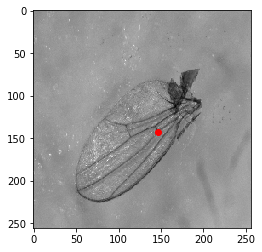

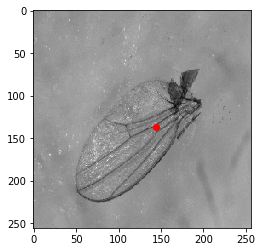

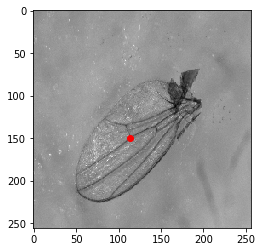

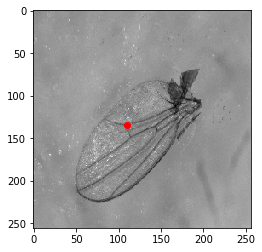

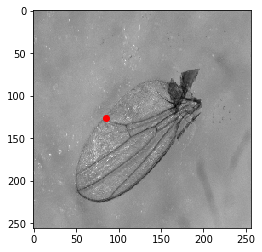

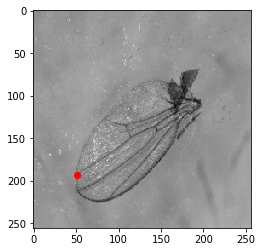

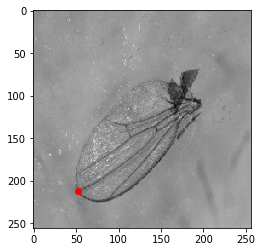

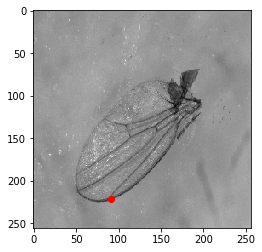

In [88]:
%matplotlib inline
dataloader_test = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

# dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
cnt=0
for batch_test in dataloader_test:
    cnt+=1
    if cnt < 0:
        print(cnt)
        continue
# batch_iter = iter(dataloader_test)    
# batch_test = batch_iter.__next__()

    images = batch_test[0].to(DEVICE, dtype=torch.float)
    labels = batch_test[1].to(DEVICE, dtype=torch.float)
    filename = batch_test[2]

    #Forward pass
    model.eval()
    NN_out = model(images)
    model.train()
    
    input_valid = np.squeeze(labels.cpu().detach().numpy())*KPT_DIV
    output_valid = np.squeeze(NN_out.cpu().detach().numpy())*KPT_DIV
    img_in = images[0][0].cpu().detach().numpy()
    for i in range(0, 8, 1):
        plt.figure()
        plt.imshow(img_in, cmap='gray')
        plt.scatter(input_valid[2*i], input_valid[2*i+1], c='r')
#         plt.scatter(output_valid[::2], output_valid[1::2], c='r')
#         plt.scatter(input_valid[::2], input_valid[1::2], c='b')
#         plt.show()
    break

# in_imgs = batch_test[0].numpy()
# keypoints = batch_test[1].numpy()*KPT_DIV
# path = batch_test[2]

# # print("Shape data = {}, GT = {}".format(input_valid.shape, output_valid.shape))
# for i in range(0, 8, 1):
# #     img_in = in_imgs[i][0]
#     img_in = in_imgs[0][0]
#     print("======== {} ========".format(path))
# #     print("======== {} ========".format(path[i]))
# #     print("Shape est={}, gt={}".format(img_in.shape, img_in.shape))
#     plt.figure()
#     plt.imshow(img_in, cmap='gray')
# #     plt.scatter(keypoints[i][::2], keypoints[i][1::2], c='r')
# #     plt.scatter(keypoints[0][::2], keypoints[0][1::2], c='r')
#     plt.scatter(keypoints[0][2*i], keypoints[0][2*i+1], c='r')


In [10]:
def find_best_orientation(kpts_gt, kpts_est):
    DIFF_THRESH = 0.5
    for batch in range(0, len(kpts_gt), 1):
        tmp = kpts_est[batch].clone()
        
        #no flip
        min_loss = criterion(kpts_gt[batch], tmp)
        original_loss = min_loss
        min_op = "identity"
        #horizontal flip
        tmp[0::2] = 1.0-tmp[0::2]
        loss = criterion(kpts_gt[batch], tmp)
        if loss < (min_loss*DIFF_THRESH):
            min_loss = loss
            min_op = "hor"
        #horizontal and vertical flip          
        tmp[1::2] = 1.0-tmp[1::2]
        loss = criterion(kpts_gt[batch], tmp)
        if loss < (min_loss*DIFF_THRESH):
            min_loss = loss
            min_op = "hor_ver"
        #vertical flip
        tmp[0::2] = 1.0-tmp[0::2]
        loss = criterion(kpts_gt[batch], tmp)
        if loss < (min_loss*DIFF_THRESH):
            min_loss = loss
            min_op = "ver"
                
#         if min_op=="hor":
# #             print("horizontal flip on {} - loss = {} v {}".format(batch, min_loss, original_loss))
#             kpts_est[batch, 0::2] = 1.0-kpts_est[batch, 0::2]
#         elif min_op=="hor_ver":
# #             print("double flip on {} - loss = {} v {}".format(batch, min_loss, original_loss))
#             kpts_est[batch, :] = 1.0-kpts_est[batch, :]
#         elif  min_op=="ver":
# #             print("vertical flip on {} - loss = {} v {}".format(batch, min_loss, original_loss))
#             kpts_est[batch, 1::2] = 1.0-kpts_est[batch, 1::2]

    
    return original_loss, min_loss, min_op

In [101]:
from IPython import display
import pylab as pl
import time

fix_automatically = False
dataloader_test = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=False)
cnt=0
incorrect_label_order = []
show_dp = 5
colors = [0,1,2,3,4,5,6,7]
leg_pts_x = np.arange(0, RESIZE[0], RESIZE[0]/8)
leg_pts_y = np.full((8), RESIZE[0])
corrupted = []
for batch_test in dataloader_test:
    cnt+=1
    if cnt < 0:
        if cnt%100==0:
            print(cnt)
        continue

    images = batch_test[0].to(DEVICE, dtype=torch.float)
    labels = batch_test[1].to(DEVICE, dtype=torch.float)
    filename = batch_test[2]
    
    #Forward pass
    model.eval()
    NN_out = model(images)
    model.train()
    loss, min_loss, min_op = find_best_orientation(NN_out, labels)
    print("{}: {:0.8f}, {:0.8f}, {}".format(cnt, loss, min_loss, min_op))
    if fix_automatically:
        if cnt%250==0:
            print(cnt)
        if min_op == "hor":
            print("{}: Flipping {} horizontally".format(cnt, filename[0]))
            img = cv.imread(filename[0])
            img = cv.flip(img, 1)
            cv.imwrite(filename[0], img)
        if min_op == "ver":
            print("{}: Flipping {} vertically".format(cnt, filename[0]))
            img = cv.imread(filename[0])
            img = cv.flip(img, 0)
            cv.imwrite(filename[0], img)
        if min_op == "hor_ver":
            print("{}: Flipping {} horizontally then vertically".format(cnt, filename[0]))
            img = cv.imread(filename[0])
            img = cv.flip(img, 1)
            img = cv.flip(img, 0)
            cv.imwrite(filename[0], img)
        if min_op is not "identity":
            print("loss={:0.8f}, flip_loss={:0.8f}".format(loss, min_loss))
    else:
#         if loss.item() > 0.01 or min_op is not "identity":
#             print("{}: {} = {}".format(cnt, filename[0], loss.item()))
#             os.remove(filename[0])
        print("{}: {} = {}".format(cnt, filename, loss.item()))
        if loss.item() > 0.01 or min_op is not "identity":
    #         print(filename)
            input_valid = np.squeeze(labels.cpu().detach().numpy())*KPT_DIV
            output_valid = np.squeeze(NN_out.cpu().detach().numpy())*KPT_DIV
            img_in = images[0][0].cpu().detach().numpy()
            plt.figure()
            plt.imshow(img_in, cmap='gray')
            plt.scatter(output_valid[::2], output_valid[1::2], c='r', marker='x')
    #         plt.scatter(input_valid[::2], input_valid[1::2], c='b')
            plt.scatter(input_valid[::2], input_valid[1::2], c=colors, cmap='rainbow')
            plt.scatter(leg_pts_x, leg_pts_y, c=colors, cmap='rainbow')

            display.clear_output(wait=True)
            display.display(plt.gcf())
            input_txt = input("Continue...{}: loss={:0.8f}, flip_loss={:0.8f} path={} - suggested op={}".format(
                cnt, loss.item(), min_loss, filename[0], min_op))
            if input_txt == "v":
                img = cv.imread(filename[0])
                img = cv.flip(img, 0)
                cv.imwrite(filename[0], img)
    #             plt.imshow(img_in, cmap='gray')
            if input_txt == "h":
                img = cv.imread(filename[0])
                img = cv.flip(img, 1)
                cv.imwrite(filename[0], img)
            if input_txt == "hv" or input_txt == "vh":
                img = cv.imread(filename[0])
                img = cv.flip(img, 1)
                img = cv.flip(img, 0)
                cv.imwrite(filename[0], img)
    #             plt.imshow(img_in, cmap='gray')
            if input_txt == "d":
                os.remove(filename[0])
            if input_txt == "i":
                incorrect_label_order.append(filename[0])

            input("Action={}: loss={:0.8f} path={}".format(input_txt, loss.item(), filename[0]))
            plt.close()

print(incorrect_label_order)

1: 0.00003753, 0.00003753, identity
1: ('/storage/data_storage/wings/wings/clem_wings/clem_wings/B.P_SS.xch/B.pss.xch.130.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/C.F1_NS.xch/C.F1NS.116.tif', '/storage/data_storage/wings/wings/teresa_wings/RunK_Wings/image0077.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 45/S45 photos/45F2S119B25.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/B.F2_NS.xch/B.F2NS.90.tif', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/26.1L.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R2/B3R2.s3/32.98.tif', '/storage/data_storage/wings/wings/teresa_wings/RunO_Wings/image0086.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 4/B4R1/B4R1.s3/41.149.tif', '/storage/data_storage/wings/wings/ness_wings_2/1stround/dc3-0013.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R4/B1R4.s1/14.140.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/parentsland.TPS/P-K135-F.bmp

3: 0.00007834, 0.00007834, identity
3: ('/storage/data_storage/wings/wings/sandra_wings/Block 4/B4R3/B4R3.s1/43.203.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/B.F2_SN.xch/B.f2sn.xch.16.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R4/B1R4.s5/14.343.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/C.F1_SN.xch/C.f1sn.xch.211.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/B.P_SS.xch/B.pss.xch.127.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/landmarkgofh&k.TPS/go-f125-F.bmp', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/offland.TPS/O-K162-M.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 2/B2R1/B2R1.s1/15.368.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 50/S50 photos/50F2S144E25.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 48/S48 S130 S131 photos/48F1S130E18.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/offspringtps.TPS/O_45_1_F.bmp', '/stor

5: 0.00043844, 0.00043844, identity
5: ('/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R4/B1R4.s5/14.350.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 41/SIRE 95/41M2S95E25.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/parentsland.TPS/P-F112-M.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 4/B4R1/B4R1.s3/41.13.tif', '/storage/data_storage/wings/wings/tamblyn_wings/Species Comp 2015/Scale 06/C/28rubC_24_s06.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/landmarkgofh&k.TPS/GO-K222-M.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R3/B3R3.s1/33.84.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 49/S49 sires 137 142/49M1S137C18.tif', '/storage/data_storage/wings/wings/fiona_wings/BIR17 - BODY SIZE/BODY SIZE measurements/Session 6 5M 10F 1M 2M/5M35.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 4/B4R4/B1R1.s2/44.170.l.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/B.F1_N

7: 0.00066227, 0.00066227, identity
7: ('/storage/data_storage/wings/wings/ness_wings_2/PhDwings/fh&mparlan.TPS/P-F205-M.bmp', '/storage/data_storage/wings/wings/clem_wings/clem_wings/C.P_NN.xch/C.PNN.062.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 52/S52 photos/52F1S157D18.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 4/B4R1/B4R1.s4/41.88.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R2/B3R2.s3/32.91.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R3/B1R3.s3/13-34.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 46/S46 photos/46M2S123D18.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/C.F2_NS.xch/C.F2NS.091.tif', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/G.1.30R.bmp', '/storage/data_storage/wings/wings/ness_wings_2/1stround/bc3-0009.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 50/S50 photos/50F2S147D18.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 42/SIRE 102/42M2S102

9: 0.00052188, 0.00052188, identity
9: ('/storage/data_storage/wings/wings/sandra_wings/Block 4/B4R2/B4R2.s5/42.329.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 2/B2R3/B2R3.s3/23.376.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/offland.TPS/O-K61-M.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 2/B2R1/B2R1.s2/15.140.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R1/B1R1.s1/74.255.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/offland.TPS/O-K153-F.bmp', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/parentsland.TPS/P-K128-F.bmp', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/fh&mparlan.TPS/P-F205-F.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R1/B1R1.s2/image0003.82.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/C.P_NN.xch/C.PNN.225.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R2/B3R2.s4/32.48.tif', '/storage/data_storage/wings/wings/ne

11: 0.00063742, 0.00063742, identity
11: ('/storage/data_storage/wings/wings/teresa_wings/RunG_Wing/G38.tif', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/R.03.23L.bmp', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/17.3.1R.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R3/B3R3.s2/33.249.tif', '/storage/data_storage/wings/wings/ness_wings_2/1stround/hc1-0009.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/B.F2_SN.xch/B.f2sn.xch.3.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/C.F1_NS.xch/C.F1NS.187.tif', '/storage/data_storage/wings/wings/teresa_wings/RunK_Wings/image0068.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/offspringtps.TPS/O_64_2_F.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R4/B3R4.s3/34.172.tif', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/105.3.1L.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 2/B2R4/B2R4.s2/24.61.tif', '/storage/data_storage/wings/

13: 0.00006868, 0.00006868, identity
13: ('/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R1/B1R1.s3/image0004.373.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 50/S50 photos/50F1S146A25.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 4/B4R2/B4R2.s4/42.79.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 43/Sire 111/43M2S111C25.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/C.F2_SN.xch/C.F2SN.107.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/B.F1_SN.xch/B.f1sn.xch.16.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R1/B3R1.s2/31.363.tif', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/17.1R.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R1/B3R1.s2/31.38.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 41/SIRE 96/41F1S96A18.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 43/Sire 106/43F1S106E28.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R1

15: 0.00010315, 0.00010315, identity
15: ('/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R2/B1R2.s1/12-281.tif', '/storage/data_storage/wings/wings/fiona_wings_2/BUNN SUMMER/2. CHECKING/58cm1.tif', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/173.1.5L.bmp', '/storage/data_storage/wings/wings/shaun_wings/F2 28/F2 28 INNIS 8/F228.8.W18.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 2/B2R4/B2R4.s1/24.65.tif', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/R.3.14R.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R3/B1R3.s3/13-10.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 55/SIRE 176/55M1S176C25.tif', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/G.03.22L.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R3/B3R3.s4/33.44.tif', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/53.4.1L.bmp', '/storage/data_storage/wings/wings/clem_wings/clem_wings/B.F2_SN.xch/B.f2sn.xch.111.tif', '/storage/data_stor

17: 0.00002036, 0.00002036, identity
17: ('/storage/data_storage/wings/wings/fiona_wings_2/BUNN SUMMER/2. 2011-11-28/58cm3.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/landmarkgofh&k.TPS/GO-K105-M.bmp', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/106.3.3L.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R4/B1R4.s2/14.315.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/B.P_NN.xch/B.pnn.xch.94.tif', '/storage/data_storage/wings/wings/teresa_wings/RunC_Wings/Sesion2/C11.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/fh&mparlan.TPS/P-F83-F.bmp', '/storage/data_storage/wings/wings/fiona_wings_2/BUNN SUMMER/2. CHECKING/57cf2.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/parentsland.TPS/P-K2-M.bmp', '/storage/data_storage/wings/wings/zoe_wings/Slide 44/S44 sires 113 115/44M1S113A18.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 48/S48 S130 S131 photos/48F1S131C28.tif', '/storage/data_storage/w

19: 0.00010491, 0.00010491, identity
19: ('/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R1/B3R1.s1/31.100.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R3/B3R3.s4/33.251.tif', '/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R3/B1R3.s2/13-222.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/offland.TPS/O-K225-M.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R2/B1R2.s4/12-348.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/landmarkgofh&k.TPS/GO-K71-F.bmp', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/106.2.1L.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R4/B1R4.s1/14.153.tif', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/G.1.28R.bmp', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/46.2.5L.bmp', '/storage/data_storage/wings/wings/ness_wings_2/1stround/gc2-0006.tif', '/storage/data_storage/wings/wings/zoe_wings/Slide 41/SIRE 96/41F1S96E28.tif', '/storage/data_st

21: 0.00007348, 0.00007348, identity
21: ('/storage/data_storage/wings/wings/sandra_wings/Block 2/B2R2/B2R2.s1/22.41.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/offland.TPS/O-F117-M.bmp', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/R.1.14L.bmp', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/173.1.4L.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 2/B2R2/B2R2.s3/22.207.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/landmarkgofh&k.TPS/GO-K172-M.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R1/B3R1.s5/31.227.tif', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/parentsland.TPS/P-K94-F.bmp', '/storage/data_storage/wings/wings/ness_wings_3/HSP90/74.1.4R.bmp', '/storage/data_storage/wings/wings/ness_wings_2/PhDwings/offland.TPS/O-K167-F.bmp', '/storage/data_storage/wings/wings/sandra_wings/Block 4/B4R1/B4R1.s3/41.156.tif', '/storage/data_storage/wings/wings/clem_wings/clem_wings/B.F1_SN.xch/B.f1sn.xch

KeyboardInterrupt: 

In [7]:
# output_linear = torch.nn.Linear(512, 16, bias=True)
# model = models.resnet34(pretrained=True)
# model.fc = output_linear

# model = torch.load("/storage/data/models/wings_resnet34_gs_all_1mlp_512x512", map_location=DEVICE)
model = torch.load("/storage/data/wing_models/wings_resnet34_gs_all_1mlp_very_good", map_location=DEVICE)
# model.to(DEVICE)

In [ ]:
# for param in model.parameters():
#     param.requires_grad = True

In [ ]:
# model.conv1.requires_grad = False
# model.bn1.requires_grad = False

# for param in model.layer1.parameters():
#     param.requires_grad = False
    
# for param in model.layer2.parameters():
#     param.requires_grad = False
    
# for param in model.layer3.parameters():
#     param.requires_grad = False
    
# for param in model.parameters():
#     print(param.requires_grad)

In [8]:
criterion = nn.MSELoss()

optim = torch.optim.Adam(model.parameters())
#Loss tracking
loss_arr = []
valid_arr = []

In [ ]:
def flip_loss(kpts_gt, kpts_est):
    DIFF_THRESH = 0.1
    for batch in range(0, len(kpts_gt), 1):
        tmp = kpts_est[batch].clone()
        
        #no flip
        min_loss = criterion(kpts_gt[batch], tmp)
        original_loss = min_loss
        min_op = "identity"
        #horizontal flip
        tmp[0::2] = 1.0-tmp[0::2]
        loss = criterion(kpts_gt[batch], tmp)
        if loss < min_loss*DIFF_THRESH:
            min_loss = loss
            min_op = "hor"
        #horizontal and vertical flip          
        tmp[1::2] = 1.0-tmp[1::2]
        loss = criterion(kpts_gt[batch], tmp)
        if loss < min_loss*DIFF_THRESH:
            min_loss = loss
            min_op = "hor_ver"
        #vertical flip
        tmp[0::2] = 1.0-tmp[0::2]
        loss = criterion(kpts_gt[batch], tmp)
        if loss < min_loss*DIFF_THRESH:
            min_loss = loss
            min_op = "ver"
                
        if min_op=="hor":
#             print("horizontal flip on {} - loss = {} v {}".format(batch, min_loss, original_loss))
            kpts_est[batch, 0::2] = 1.0-kpts_est[batch, 0::2]
        elif min_op=="hor_ver":
#             print("double flip on {} - loss = {} v {}".format(batch, min_loss, original_loss))
            kpts_est[batch, :] = 1.0-kpts_est[batch, :]
        elif  min_op=="ver":
#             print("vertical flip on {} - loss = {} v {}".format(batch, min_loss, original_loss))
            kpts_est[batch, 1::2] = 1.0-kpts_est[batch, 1::2]

    
    return criterion(kpts_gt, kpts_est)
    

In [ ]:
def invariant_mse_loss(kpts_gt, kpts_est):
    cnt = 0
    mse_loss = 0
    for batch_id in range(0, len(kpts_gt), 1):
        available_indices = list(range(0, len(kpts_est[batch_id])))
        for estimated in kpts_est[batch_id]:
            min_loss = 1e10
            min_idx = -1
            for available_index in available_indices:
                loss = (estimated - kpts_gt[batch_id][available_index])**2
                if loss < min_loss:
                    min_loss = loss
                    min_idx = available_index
            mse_loss += min_loss
            cnt += 1
            available_indices.remove(min_idx)
    mse_loss /= cnt
    return mse_loss    

In [ ]:
# BATCH_SIZE = 4
# keyps = torch.tensor([[0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8],
#                      [0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8],
#                      [0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8],
#                      [0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8]])
# keyps_flipped = keyps.clone()
# keyps_flipped[0, 0::2] = 1-keyps_flipped[0, 0::2]
# keyps_flipped[1, 0::2] = 1-keyps_flipped[1, 0::2]
# print(keyps_flipped.shape)
# # print(keyps)
# # print(keyps_flipped)
# invariant_loss = invariant_mse_loss(keyps, keyps_flipped)
# flip_loss = invariant_mse_loss(keyps, keyps_flipped)
# mse_loss = criterion(keyps, keyps_flipped)
# print("MSE={}, flip={}, invar={}".format(mse_loss, flip_loss, invariant_loss))
# BATCH_SIZE = 32

In [ ]:
N_ITERS = 30
lr = 0.0001
use_flip_loss = False
use_flip_loss_valid = False
epoch = 0
if TRAIN:
    t = tqdm(range(N_ITERS), desc="epoch: ")
    for i in t:
        optim = torch.optim.Adam(model.parameters(), lr)
        rec = True
        inner = tqdm(dataloader, "batch: ", leave=False)
        for batch in inner:
            optim.zero_grad()
            images = batch[0].to(DEVICE, dtype=torch.float)
            labels = batch[1].to(DEVICE, dtype=torch.float)

            #Forward pass
            NN_out = model(images)
            if use_flip_loss:
#                 loss = invariant_mse_loss(NN_out, labels)
                loss = flip_loss(NN_out, labels)
            else:
                loss = criterion(NN_out, labels)

            #Training
            loss.backward()
            optim.step()

            loss_arr.append(loss.item())
            
            model.eval()
            #Validation loss
            batch_iter_valid = iter(dataloader_valid)    
            batch_valid = batch_iter_valid.__next__()
            input_valid = batch_valid[0].to(DEVICE, dtype=torch.float)
            label_valid = batch_valid[1].to(DEVICE, dtype=torch.float)
            output_valid = model(input_valid)
            if use_flip_loss_valid:
                loss_valid = flip_loss(output_valid, label_valid)
#                 print("Flip loss = {}".format(loss_valid))
#                 loss_valid = invariant_mse_loss(output_valid, label_valid)
#                 print("Invariant loss = {}".format(loss_valid))
            else:
                loss_valid = criterion(output_valid, label_valid)
            valid_arr.append(loss_valid.item())

            model.train()
            inner.set_description("loss: {:.5f}, v_loss: {:.5f}".format(loss.item(), loss_valid.item()))
            #Set the first batch loss as the loss in the tqdm description
            if rec==True:
                t.set_description("loss: {:.8f}, v_loss: {:.8f}".format(loss.item(), loss_valid.item()))
                rec = False
        print("epoch {}:lr={}, loss={}, v_loss={}".format(epoch, lr, loss.item(), loss_valid.item()))
        torch.save(model, "/storage/data/models/wings_resnet34_gs_all_1mlp_256x256")
        if epoch%2 == 0:
            lr = lr*0.5
        epoch += 1

0.0001


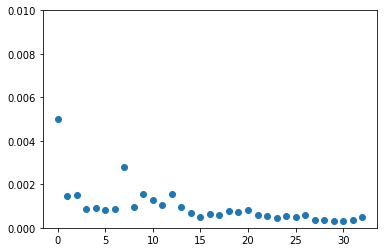

In [111]:
print(lr)
lim = 0.01
if TRAIN:
    plt.ylim(0, lim)
    plt.scatter(range(len(loss_arr[::1])), loss_arr[::1])

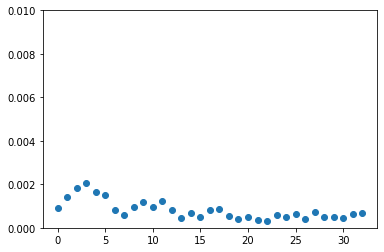

In [112]:
if TRAIN:
    plt.ylim(0, lim)
    plt.scatter(range(len(valid_arr[::1])), valid_arr[::1])

In [ ]:
print(lr)
lim = 0.01
if TRAIN:
    plt.ylim(0, lim)
    plt.scatter(range(len(loss_arr[::1])), loss_arr[::1])

In [ ]:
lim = 0.001
if TRAIN:
    plt.ylim(0, lim)
    plt.scatter(range(len(valid_arr[::1])), valid_arr[::1])

In [ ]:
loss_arr = []

In [ ]:
torch.save(model, "/storage/data/models/wings_resnet34_gs_all_1mlp_256x256")

In [113]:
dataloader_test = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
# dataloader_test = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
batch_iter = iter(dataloader_test)    
batch_test = batch_iter.__next__()

input_tensor = batch_test[0].to(DEVICE, dtype=torch.float)
gt_tensor = batch_test[1].numpy()
validation_paths = batch_test[2]

model.eval()
input_valid = (batch_test[1].cpu().detach().numpy())
output_valid = model(input_tensor).cpu().detach().numpy()
output_valid = np.squeeze(output_valid)
model.train()

print("Shape data = {}, GT = {}".format(input_valid.shape, output_valid.shape))

Shape data = (64, 16), GT = (64, 16)


In [114]:
print(gt_tensor[0])
print(output_valid[0])
print(np.mean((gt_tensor-output_valid)*(gt_tensor-output_valid)))

[0.44907793 0.31003532 0.42464399 0.3368021  0.49381715 0.53016216
 0.44323283 0.56976181 0.44245496 0.78225845 0.74721539 0.98194724
 0.82944566 0.95098484 0.81820858 0.64095044]
[0.43032506 0.29077423 0.41403374 0.30024126 0.47769222 0.5078218
 0.42767322 0.5483767  0.4098544  0.7777926  0.7176079  0.9965188
 0.8176046  0.9697626  0.8257384  0.6508422 ]
0.000287150379763059


In [115]:
err = (abs(output_valid-input_valid)/input_valid)*100
print(np.mean(err))

output_valid = output_valid*KPT_DIV
input_valid = input_valid*KPT_DIV

2.8028196498890248


/storage/data_storage/wings/wings/ness_wings_3/HSP90/173.1.511L.bmp
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/fiona_wings/BIR17 - BODY SIZE/BODY SIZE measurements/Session 6 5M 10F 1M 2M/2M35.tif
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R4/B1R4.s5/14.147.tif
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/sandra_wings/Block 2/B2R3/B2R3.s3/23.332.tif
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/ness_wings_3/HSP90/10.1.5L.bmp
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/ness_wings_3/HSP90/190.2.1R.bmp
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/sandra_wings/Block 4/B4R4/B1R1.s1/44.134.tif
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/sandra_wings/Block 1/B1R2/B1R2.s1/12-58.tif
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/shaun_wings/F2 28/F2 28 INNIS 8/F228.8.W30.tif
Shape est=(64, 16), gt=(64, 16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


/storage/data_storage/wings/wings/fiona_wings/BIR17 - BODY SIZE/BODY SIZE measurements/Session 6 5M 10F 1M 2M/1M36.tif
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/zoe_wings/Slide 49/S49 sires 137 142/49F2S142D28.tif
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/clem_wings/clem_wings/C.F1_NS.xch/C.F1NS.105.tif
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/teresa_wings/RunC_Wings/Sesion2/C87.tif
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/zoe_wings/Slide 47/S47 photos/47F2S126B28.tif
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/sandra_wings/Block 3/B3R2/B3R2.s5/32.5.tif
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/ness_wings_3/HSP90/R.03.26R.bmp
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/ness_wings_2/PhDwings/landmarkgofh&k.TPS/go-K8-M.bmp
Shape est=(64, 16), gt=(64, 16)
/storage/data_storage/wings/wings/ness_wings_3/HSP90/121.1.8R.bmp
Shape

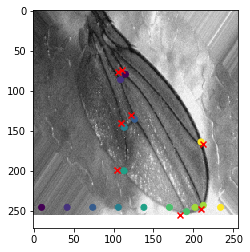

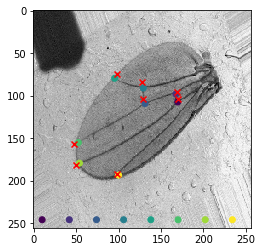

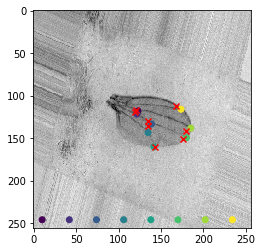

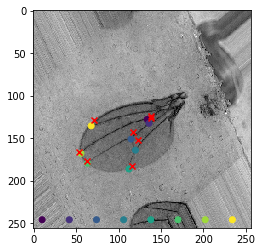

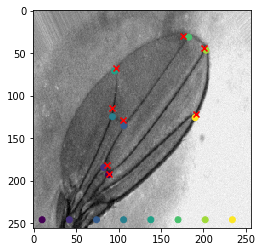

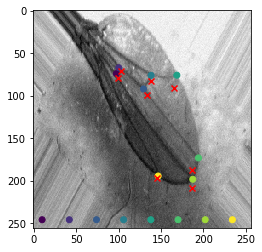

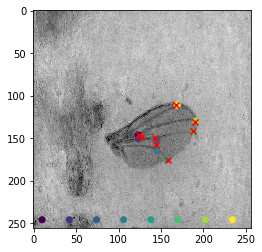

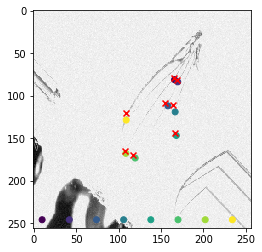

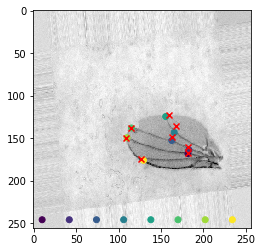

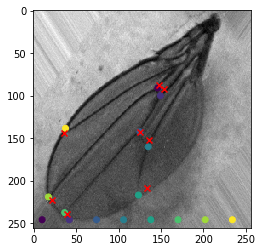

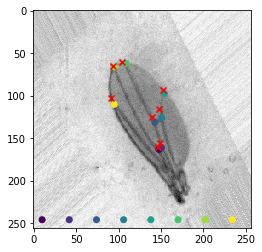

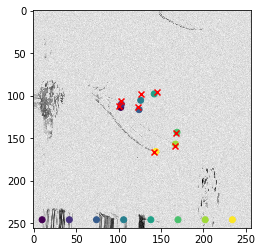

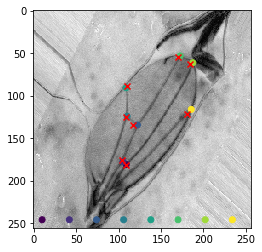

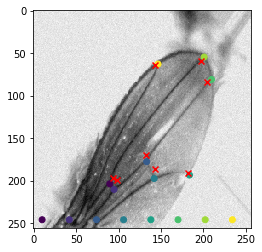

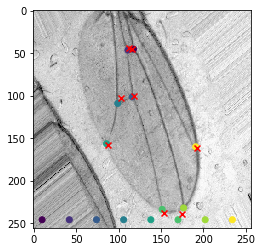

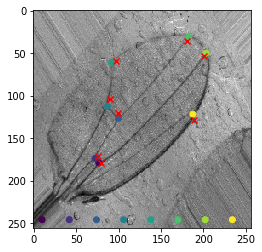

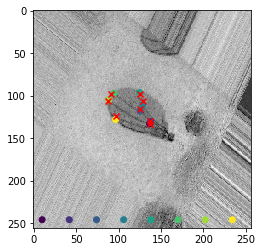

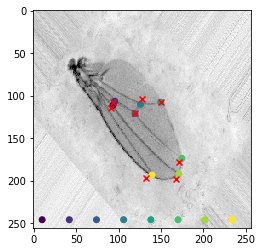

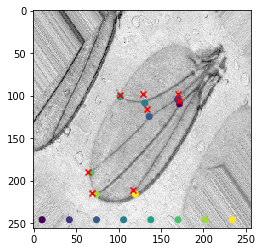

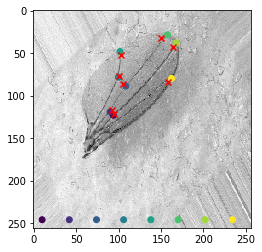

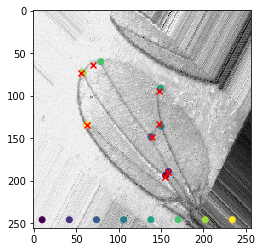

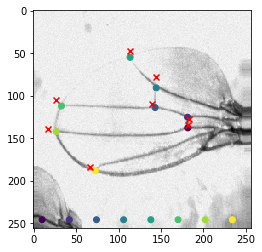

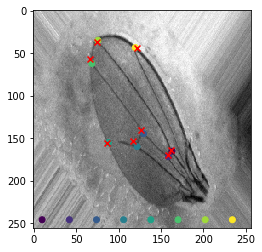

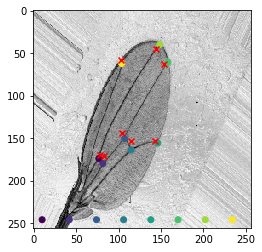

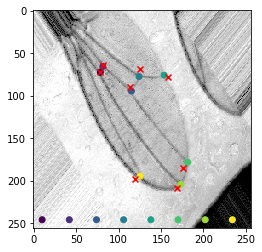

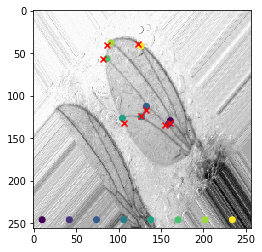

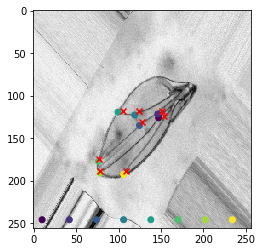

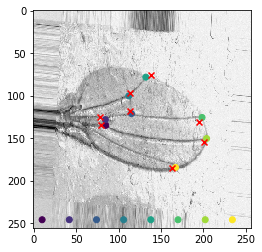

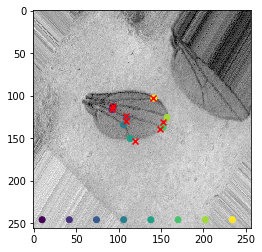

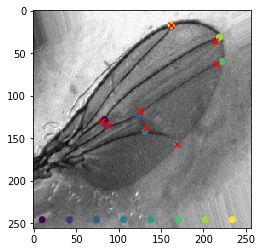

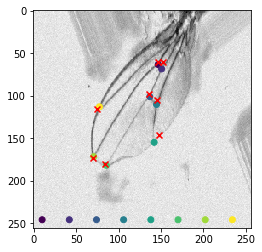

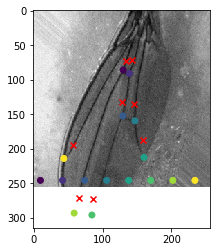

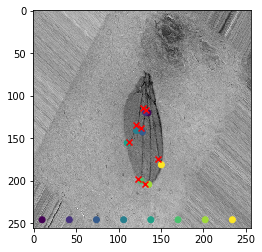

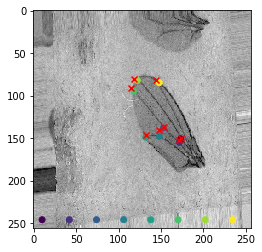

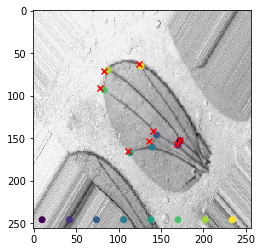

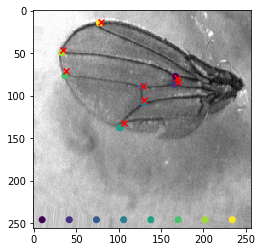

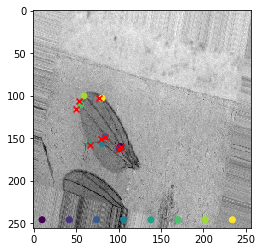

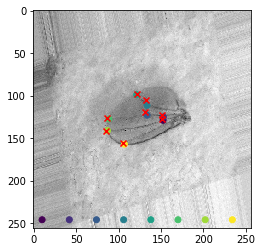

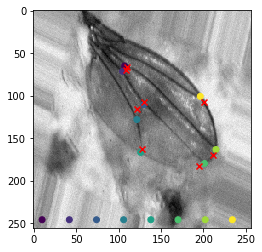

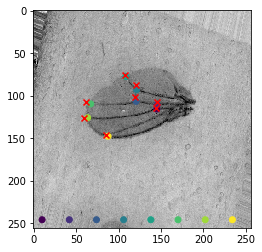

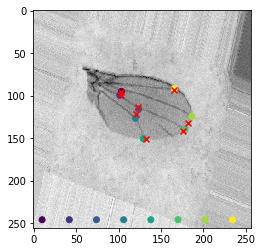

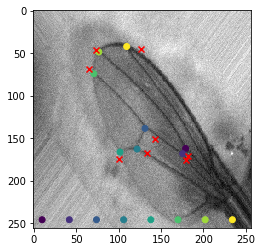

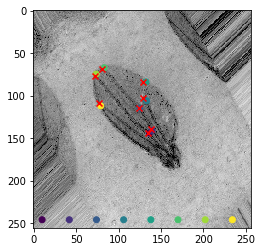

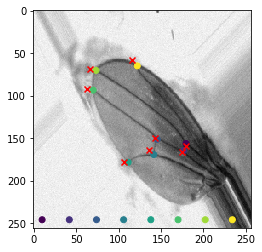

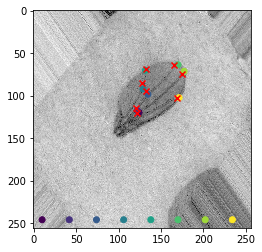

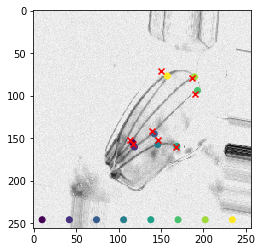

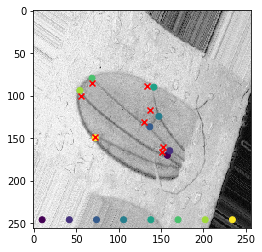

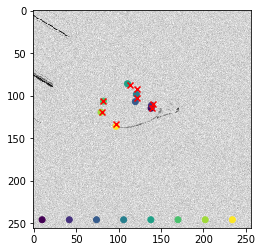

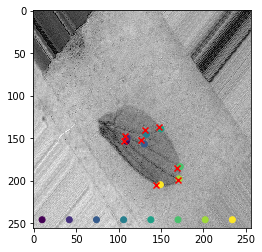

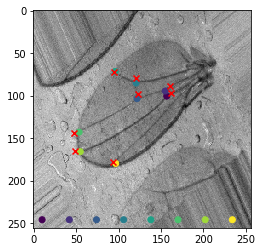

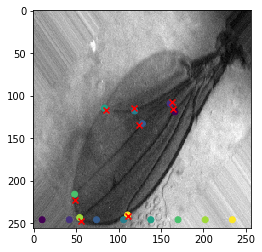

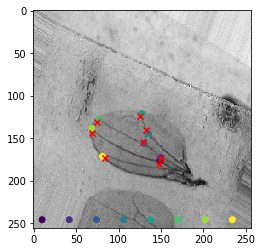

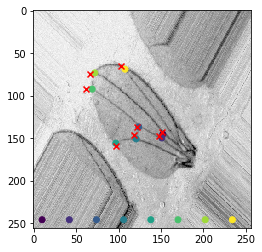

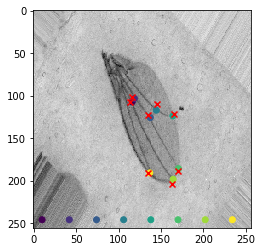

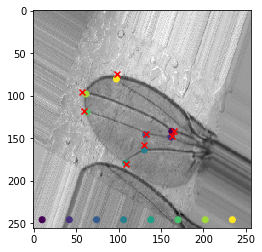

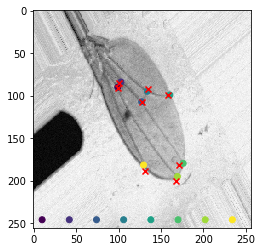

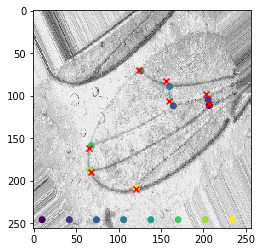

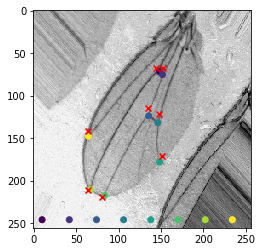

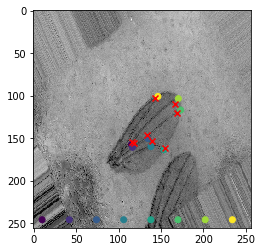

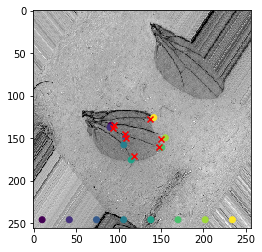

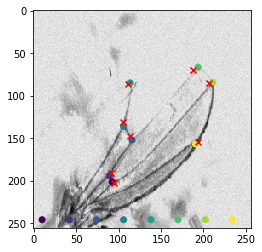

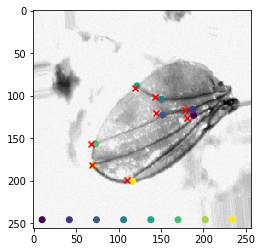

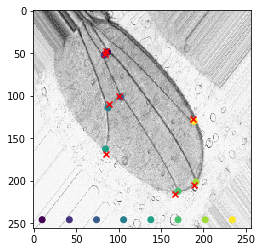

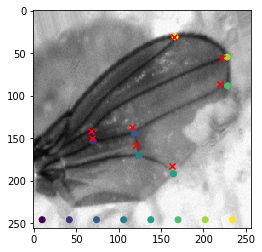

In [119]:
colors = [0,1,2,3,4,5,6,7]
colormap = 'viridis'
leg_pts_x = np.arange(10, RESIZE[0], RESIZE[0]/8)
leg_pts_y = np.full((8), RESIZE[0]-10)
strt_idx = 20
# for i in range(strt_idx, strt_idx+5, 1):
for i in range(0, BATCH_SIZE, 1):
    print(validation_paths[i])
    img_in = input_tensor[i][0].cpu().detach().numpy()
#     gt_pts = output_valid[i][0]
    print("Shape est={}, gt={}".format(output_valid.shape, input_valid.shape))

#     f, axarr = plt.subplots(1,2)
    plt.figure()
    plt.imshow(img_in, cmap='gray')
    plt.scatter(input_valid[i][::2], input_valid[i][1::2], c=colors, cmap=colormap)
    plt.scatter(leg_pts_x, leg_pts_y, c=colors, cmap=colormap)
    plt.scatter(output_valid[i][::2], output_valid[i][1::2], c='r', marker='x')
#     plt.scatter(input_valid[i][8], input_valid[i][9], c='b')
#     print(input_valid[i])
#     axarr[0].imshow(img_in, cmap='gray')